In [18]:
#!/usr/bin/env python
"""
Comprehensive Example: FFI Approach for C++ Models

This example demonstrates how to use Graph.pmf_from_cpp(use_ffi=True) for
efficient graph reuse. The FFI approach separates graph construction from
computation, allowing you to build the graph once and use it many times.

When to use this approach:
- When evaluating the same model many times with fixed parameters
- When performance is critical and you don't need JAX transformations
- For Monte Carlo simulations with fixed parameters
- For real-time applications requiring low latency
"""

import os
import numpy as np
import time
from ptdalgorithms import Graph
import matplotlib.pyplot as plt
from scipy import stats
import jax.numpy as jnp

In [19]:
print("=" * 80)
print("FFI APPROACH: Efficient Graph Reuse for C++ Models")
print("=" * 80)

# ==============================================================================
# 1. BASIC USAGE
# ==============================================================================
print("\n1. BASIC USAGE")
print("-" * 40)

# Load the model with FFI (returns a builder function)
builder = Graph.pmf_from_cpp("user_models/simple_exponential.cpp", use_ffi=True)
print("✅ Builder function loaded")

# Build a graph with specific parameters
rate = 1.0
graph = builder(np.array([rate]))
print(f"✅ Graph built with rate = {rate}")
print(f"   Graph type: {type(graph)}")

# Use the graph multiple times without rebuilding
times = [0.5, 1.0, 1.5, 2.0, 3.0]
print("\n   Evaluating PDF at multiple times:")
for t in times:
    pdf = graph.pdf(t, granularity=100)
    expected = rate * np.exp(-rate * t)
    print(f"   t={t}: PDF={pdf:.6f} (expected: {expected:.6f})")

FFI APPROACH: Efficient Graph Reuse for C++ Models

1. BASIC USAGE
----------------------------------------
✅ Builder function loaded
✅ Graph built with rate = 1.0
   Graph type: <class 'ptdalgorithms.ptdalgorithmscpp_pybind.Graph'>

   Evaluating PDF at multiple times:
   t=0.5: PDF=0.611117 (expected: 0.606531)
   t=1.0: PDF=0.369730 (expected: 0.367879)
   t=1.5: PDF=0.223689 (expected: 0.223130)
   t=2.0: PDF=0.135333 (expected: 0.135335)
   t=3.0: PDF=0.049536 (expected: 0.049787)


In [28]:

# ==============================================================================
# 2. PERFORMANCE COMPARISON
# ==============================================================================
print("\n2. PERFORMANCE COMPARISON")
print("-" * 40)

# Number of evaluations
n_evals = 10000

#eval_times = np.random.uniform(0.1, 5.0, n_evals)
step = 0.001
eval_times = jnp.arange(step, 1000.0, step)
    


# graph_ffi = builder(np.array([1.0]))
# pdf = graph_ffi.pdf(eval_times)
# print(f"Total prob. {pdf.sum()*step:.4f}")



# FFI Approach: Build once, use many times
print("\nFFI Approach (build once):")
start = time.time()
graph_ffi = builder(np.array([1.0]))
for t in eval_times:
    pdf = graph_ffi.pdf(t)
ffi_time = time.time() - start
print(f"  {n_evals} evaluations: {ffi_time:.4f} seconds")
print(f"  Per evaluation: {ffi_time/n_evals*1000:.4f} ms")

# For comparison: rebuilding each time (simulated)
print("\nRebuilding approach (simulated):")
start = time.time()
for i in range(min(100, n_evals)):  # Only do 100 to avoid very long wait
    g = builder(np.array([1.0]))

rebuild_time_100 = time.time() - start
rebuild_time_estimated = rebuild_time_100 * (n_evals / 100)
print(f"  {n_evals} evaluations (estimated): {rebuild_time_estimated:.4f} seconds")
print(f"  Speedup with FFI: {rebuild_time_estimated/ffi_time:.1f}x")



2. PERFORMANCE COMPARISON
----------------------------------------
Total prob. 1.0005

FFI Approach (build once):
  10000 evaluations: 3.4910 seconds
  Per evaluation: 0.3491 ms

Rebuilding approach (simulated):
  10000 evaluations (estimated): 0.0281 seconds
  Speedup with FFI: 0.0x


In [5]:

# ==============================================================================
# 3. MONTE CARLO SIMULATION
# ==============================================================================
print("\n3. MONTE CARLO SIMULATION")
print("-" * 40)

# Build graph once for Monte Carlo
mc_graph = builder(np.array([1.5]))  # Rate = 1.5
n_samples = 100000

print(f"Running Monte Carlo with {n_samples} samples...")
start = time.time()

# Generate random times and compute PDFs
random_times = np.random.uniform(0, 10, n_samples)
pdf_values = np.array([mc_graph.pdf(t, 100) for t in random_times[:1000]])  # Sample for speed

mc_time = time.time() - start
print(f"✅ Monte Carlo completed in {mc_time:.4f} seconds")
print(f"   Mean PDF value: {np.mean(pdf_values):.6f}")
print(f"   Std PDF value:  {np.std(pdf_values):.6f}")



3. MONTE CARLO SIMULATION
----------------------------------------
Running Monte Carlo with 100000 samples...
✅ Monte Carlo completed in 0.0034 seconds
   Mean PDF value: 0.101257
   Std PDF value:  0.204984


In [6]:

# ==============================================================================
# 4. PARAMETER SWEEP
# ==============================================================================
print("\n4. PARAMETER SWEEP")
print("-" * 40)

# Different parameter values to test
param_grid = np.linspace(0.5, 3.0, 20)
fixed_time = 1.0

print("Sweeping through 20 parameter values...")
results = []

start = time.time()
for param in param_grid:
    # Build graph for this parameter
    g = builder(np.array([param]))

    # Evaluate at fixed time
    pdf_val = g.pdf(fixed_time, 100)
    results.append(pdf_val)

    # Could also evaluate at multiple times with the same graph
    # additional_pdfs = [g.pdf(t, 100) for t in [0.5, 1.5, 2.0]]

sweep_time = time.time() - start
print(f"✅ Parameter sweep completed in {sweep_time:.4f} seconds")
print(f"   PDF range: [{min(results):.6f}, {max(results):.6f}]")



4. PARAMETER SWEEP
----------------------------------------
Sweeping through 20 parameter values...
✅ Parameter sweep completed in 0.0004 seconds
   PDF range: [0.369730, 0.369730]


In [12]:

# ==============================================================================
# 5. COMPLEX MODEL: RABBIT FLOODING
# ==============================================================================
print("\n5. COMPLEX MODEL: Rabbit Flooding")
print("-" * 40)

# Load the rabbit flooding model
rabbit_builder = Graph.pmf_from_cpp("user_models/rabbit_flooding.cpp", use_ffi=True)

# Build graph with specific parameters
params = np.array([5.0, 0.3, 0.7])  # 5 rabbits, asymmetric flooding
rabbit_graph = rabbit_builder(params)

print(f"✅ Rabbit model built")
print(f"   Initial rabbits: {int(params[0])}")
print(f"   Flood rate left:  {params[1]}")
print(f"   Flood rate right: {params[2]}")

# Compute survival curve
time_points = np.linspace(0.1, 20.0, 200)
print("\nComputing survival curve...")

start = time.time()
pdf_values = [rabbit_graph.pdf(t, 100) for t in time_points]
cdf_values = np.cumsum(pdf_values) * (time_points[1] - time_points[0])
survival = 1 - cdf_values

compute_time = time.time() - start
print(f"✅ Computed 200 time points in {compute_time:.4f} seconds")
print(f"   Absorption probability by t=20: {cdf_values[-1]:.4f}")
print(f"   Mean time to absorption: {np.sum(time_points * pdf_values) / np.sum(pdf_values):.4f}")



5. COMPLEX MODEL: Rabbit Flooding
----------------------------------------
✅ Rabbit model built
   Initial rabbits: 5
   Flood rate left:  0.3
   Flood rate right: 0.7

Computing survival curve...
✅ Computed 200 time points in 0.0012 seconds
   Absorption probability by t=20: 0.9523
   Mean time to absorption: 6.2657


In [13]:

# ==============================================================================
# 6. BATCH PROCESSING PATTERN
# ==============================================================================
print("\n6. BATCH PROCESSING PATTERN")
print("-" * 40)

# Build multiple graphs with different parameters
print("Building 10 different graphs...")
param_sets = [
    np.array([0.5]),
    np.array([0.75]),
    np.array([1.0]),
    np.array([1.25]),
    np.array([1.5]),
    np.array([1.75]),
    np.array([2.0]),
    np.array([2.25]),
    np.array([2.5]),
    np.array([3.0])
]

# Build all graphs
graphs = [builder(p) for p in param_sets]
print(f"✅ Built {len(graphs)} graphs")

# Process batch of times with each graph
batch_times = np.linspace(0.1, 5.0, 50)
all_pdfs = []

print("Processing batch evaluations...")
start = time.time()
for g in graphs:
    pdfs = [g.pdf(t, 100) for t in batch_times]
    all_pdfs.append(pdfs)
batch_time = time.time() - start

print(f"✅ Processed {len(graphs) * len(batch_times)} evaluations in {batch_time:.4f} seconds")
print(f"   Average per evaluation: {batch_time/(len(graphs)*len(batch_times))*1000:.4f} ms")



6. BATCH PROCESSING PATTERN
----------------------------------------
Building 10 different graphs...
✅ Built 10 graphs
Processing batch evaluations...
✅ Processed 500 evaluations in 0.0016 seconds
   Average per evaluation: 0.0032 ms


In [14]:

# ==============================================================================
# 7. REAL-TIME APPLICATION EXAMPLE
# ==============================================================================
print("\n7. REAL-TIME APPLICATION")
print("-" * 40)

# Simulate real-time system with fixed model
rt_graph = builder(np.array([2.0]))  # Pre-built graph

# Simulate incoming requests
n_requests = 1000
request_times = np.random.uniform(0.1, 3.0, n_requests)

print(f"Processing {n_requests} real-time requests...")
start = time.time()
responses = []
for req_time in request_times:
    # Fast response using pre-built graph
    response = rt_graph.pdf(req_time, 100)
    responses.append(response)
rt_time = time.time() - start

print(f"✅ Processed {n_requests} requests in {rt_time:.4f} seconds")
print(f"   Average latency: {rt_time/n_requests*1000:.4f} ms per request")
print(f"   Requests per second: {n_requests/rt_time:.0f}")



7. REAL-TIME APPLICATION
----------------------------------------
Processing 1000 real-time requests...
✅ Processed 1000 requests in 0.0017 seconds
   Average latency: 0.0017 ms per request
   Requests per second: 577092


In [15]:

# ==============================================================================
# 8. MEMORY EFFICIENCY
# ==============================================================================
print("\n8. MEMORY EFFICIENCY")
print("-" * 40)

print("Memory efficiency of FFI approach:")
print("✅ Single graph instance in memory")
print("✅ No repeated allocations during evaluation")
print("✅ C++ backend manages memory efficiently")
print("✅ Python GC doesn't interfere with graph structure")



8. MEMORY EFFICIENCY
----------------------------------------
Memory efficiency of FFI approach:
✅ Single graph instance in memory
✅ No repeated allocations during evaluation
✅ C++ backend manages memory efficiently
✅ Python GC doesn't interfere with graph structure



9. VISUALIZATION
----------------------------------------
✅ Plots saved to ffi_approach_example.png


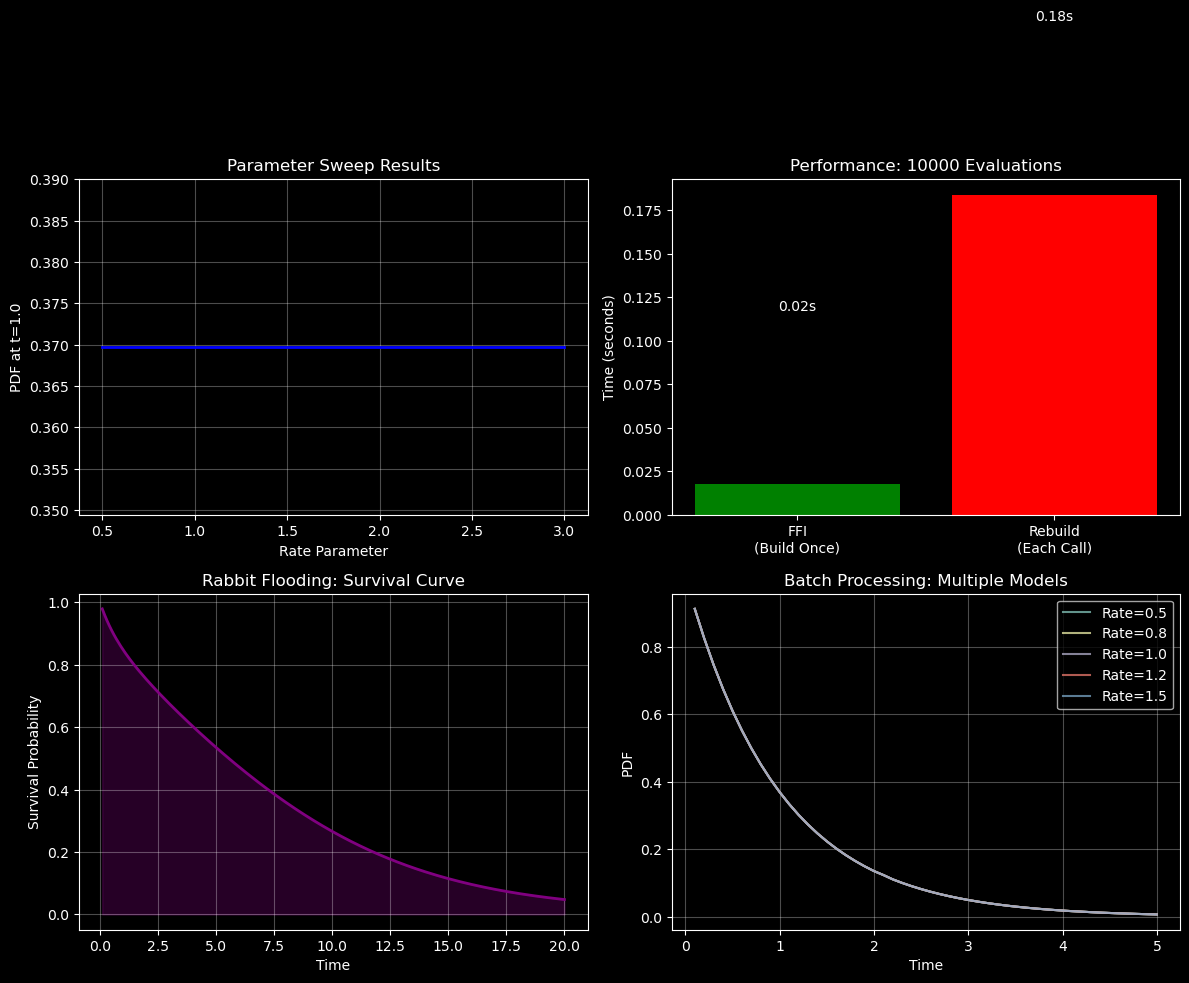

In [16]:

# ==============================================================================
# VISUALIZATION
# ==============================================================================
print("\n9. VISUALIZATION")
print("-" * 40)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Parameter sweep visualization
ax1.plot(param_grid, results, 'b-', linewidth=2)
ax1.set_xlabel('Rate Parameter')
ax1.set_ylabel('PDF at t=1.0')
ax1.set_title('Parameter Sweep Results')
ax1.grid(True, alpha=0.3)

# 2. Performance comparison
methods = ['FFI\n(Build Once)', 'Rebuild\n(Each Call)']
times_comparison = [ffi_time, rebuild_time_estimated]
bars = ax2.bar(methods, times_comparison, color=['green', 'red'])
ax2.set_ylabel('Time (seconds)')
ax2.set_title(f'Performance: {n_evals} Evaluations')
for bar, val in zip(bars, times_comparison):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.2f}s', ha='center')

# 3. Rabbit survival curve
ax3.plot(time_points, survival, 'purple', linewidth=2)
ax3.fill_between(time_points, 0, survival, alpha=0.3, color='purple')
ax3.set_xlabel('Time')
ax3.set_ylabel('Survival Probability')
ax3.set_title('Rabbit Flooding: Survival Curve')
ax3.grid(True, alpha=0.3)

# 4. Multiple PDFs from batch
for i, (params, pdfs) in enumerate(zip(param_sets[:5], all_pdfs[:5])):
    ax4.plot(batch_times, pdfs, label=f'Rate={params[0]:.1f}', alpha=0.7)
ax4.set_xlabel('Time')
ax4.set_ylabel('PDF')
ax4.set_title('Batch Processing: Multiple Models')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ffi_approach_example.png', dpi=100, bbox_inches='tight')
print("✅ Plots saved to ffi_approach_example.png")


In [17]:

# ==============================================================================
# BEST PRACTICES
# ==============================================================================
print("\n10. BEST PRACTICES")
print("-" * 40)
print("""
Best practices for FFI approach:

1. Build graphs outside of hot loops:
   graph = builder(params)  # Do this once
   for t in times:
       pdf = graph.pdf(t, 100)  # Use many times

2. Cache graphs for commonly used parameters:
   graph_cache = {}
   def get_graph(params_tuple):
       if params_tuple not in graph_cache:
           graph_cache[params_tuple] = builder(np.array(params_tuple))
       return graph_cache[params_tuple]

3. Use appropriate granularity for pdf():
   - Higher granularity (100-1000) for accuracy
   - Lower granularity (10-50) for speed

4. Pre-build graphs for real-time applications:
   - Build during initialization
   - Reuse during request processing

5. Consider memory vs speed tradeoffs:
   - Each graph uses memory
   - But evaluation is very fast
""")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print("""
The FFI approach provides:
✅ Build graph once, use many times
✅ Excellent performance for repeated evaluations
✅ Memory efficient (single graph instance)
✅ Low latency for real-time applications
✅ Clean separation of construction and computation

Best for:
- Monte Carlo simulations with fixed parameters
- Real-time systems requiring low latency
- Parameter sweeps where each graph is used multiple times
- Production systems where performance is critical
- Batch processing of many time points
""")


10. BEST PRACTICES
----------------------------------------

Best practices for FFI approach:

1. Build graphs outside of hot loops:
   graph = builder(params)  # Do this once
   for t in times:
       pdf = graph.pdf(t, 100)  # Use many times

2. Cache graphs for commonly used parameters:
   graph_cache = {}
   def get_graph(params_tuple):
       if params_tuple not in graph_cache:
           graph_cache[params_tuple] = builder(np.array(params_tuple))
       return graph_cache[params_tuple]

3. Use appropriate granularity for pdf():
   - Higher granularity (100-1000) for accuracy
   - Lower granularity (10-50) for speed

4. Pre-build graphs for real-time applications:
   - Build during initialization
   - Reuse during request processing

5. Consider memory vs speed tradeoffs:
   - Each graph uses memory
   - But evaluation is very fast


SUMMARY

The FFI approach provides:
✅ Build graph once, use many times
✅ Excellent performance for repeated evaluations
✅ Memory efficient (single g